### Testing keras tuner on whether dataset, source: https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

In [3]:
#df.to_csv('./datasets/climate_2009_2016.csv')

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

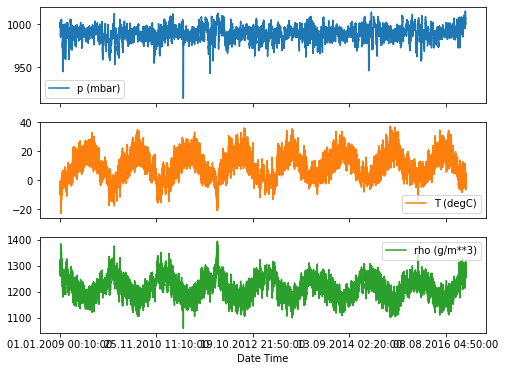

In [4]:
features.plot(subplots=True)

In [5]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [6]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset_standardized = (dataset-data_mean)/data_std

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days. For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(i.e. 12*6) observations is used.

In [8]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset_standardized, dataset_standardized[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP) #aquí el param. single_step=False
x_val_multi, y_val_multi = multivariate_data(dataset_standardized, dataset_standardized[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP) #aquí el param. single_step=False

In [9]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


### Split checks

In [12]:
# TRAIN FEATURES CHECK
dataset_standardized[:14]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.96154485, -2.04281897,  2.28524007],
       [ 0.95668784, -2.05439744,  2.29600633],
       [ 0.95425934, -2.0312405 ,  2.27031412],
       [ 0.95425934, -2.02660912,  2.26566506],
       [ 0.95304508, -2.00113649,  2.23777066],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.95304508, -1.95134907,  2.18467344],
       [ 0.95304508, -1.98492663,  2.22088721],
       [ 0.95668784, -2.04513467,  2.28646351],
       [ 0.96761611, -2.08334362,  2.33026261],
       [ 0.96761611, -2.09723778,  2.34518855],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.98218713, -2.09144854,  2.34274168]])

In [13]:
#FEATURTES start
assert len(x_train_multi[0])==120
assert len(y_train_multi[0])==72
x_train_multi[:3]

array([[[ 0.95547359, -1.99766294,  2.2350791 ],
        [ 0.95304508, -1.95134907,  2.18442875],
        [ 0.96883036, -2.09376424,  2.34176293],
        ...,
        [ 0.9627591 , -2.26396773,  2.52919369],
        [ 1.0186147 , -2.3125973 ,  2.59672749],
        [ 1.06475628, -2.45385463,  2.76164698]],

       [[ 0.96154485, -2.04281897,  2.28524007],
        [ 0.95304508, -1.95134907,  2.18467344],
        [ 0.98218713, -2.09144854,  2.34274168],
        ...,
        [ 0.97854438, -2.27438836,  2.54460901],
        [ 1.02711446, -2.32880716,  2.61654719],
        [ 1.07568454, -2.47701156,  2.78978607]],

       [[ 0.95668784, -2.05439744,  2.29600633],
        [ 0.95304508, -1.98492663,  2.22088721],
        [ 0.9906869 , -2.07176515,  2.32365604],
        ...,
        [ 0.98704414, -2.2778619 ,  2.55097089],
        [ 1.02954297, -2.35312194,  2.64321815],
        [ 1.0793273 , -2.49322142,  2.80813764]]])

In [14]:
x_train_multi[0][:5]

array([[ 0.95547359, -1.99766294,  2.2350791 ],
       [ 0.95304508, -1.95134907,  2.18442875],
       [ 0.96883036, -2.09376424,  2.34176293],
       [ 0.99797241, -2.09260639,  2.34812481],
       [ 1.01982895, -2.13776242,  2.40317953]])

In [15]:
# TRAIN TARGET CHECK
dataset_standardized[718:723]

array([[ 1.07568454, -2.52100975,  2.83774485],
       [ 1.08661281, -2.53143037,  2.85193674],
       [ 1.08904132, -2.54879807,  2.87151175],
       [ 1.08782707, -2.56616578,  2.89010801],
       [ 1.08904132, -2.58121779,  2.90699146]])

In [16]:
#FEATURTES end
x_train_multi[0][-5:]

array([[ 0.76240751, -1.9965051 ,  2.19030125],
       [ 0.87290445, -2.15165658,  2.38507265],
       [ 0.9627591 , -2.26396773,  2.52919369],
       [ 1.0186147 , -2.3125973 ,  2.59672749],
       [ 1.06475628, -2.45385463,  2.76164698]])

In [17]:
y_train_multi[0][:5]

array([-2.54879807, -2.56616578, -2.58121779, -2.59048056, -2.60205903])

In [18]:
y_train_multi[1][:5]

array([-2.56616578, -2.58121779, -2.59048056, -2.60205903, -2.6136375 ])

In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

### Comprobamos lo que hace 'shuffle(BUFFER_SIZE) y batch(BATCH_SIZE)'

In [24]:
for x, y in train_data_multi.take(2):
    print(x[0][-1])
    print(y[0][0])

tf.Tensor([-0.40206024 -1.42105518  1.28153122], shape=(3,), dtype=float64)
tf.Tensor(-1.4164237970184996, shape=(), dtype=float64)
tf.Tensor([-1.71102399 -0.75413537  0.27659892], shape=(3,), dtype=float64)
tf.Tensor(-0.4264646914851534, shape=(), dtype=float64)


### Seguimos con el modelado

In [26]:
def create_time_steps(length):
  return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [27]:
temps_mean = data_mean[1]
temps_std = data_std[1]

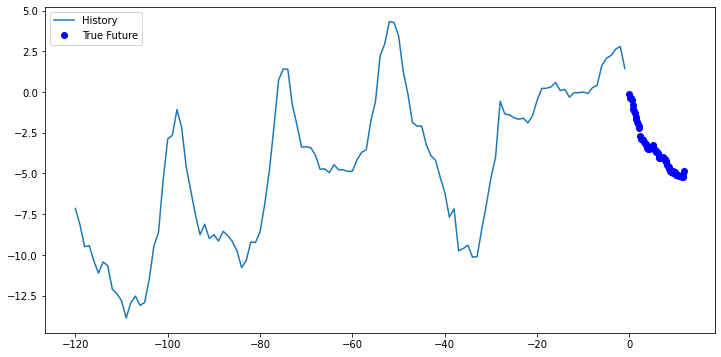

In [28]:
for x, y in train_data_multi.take(1):
  x_denormalized = (x[0])*temps_std+temps_mean
  y_denormalized = (y[0])*temps_std+temps_mean

  multi_step_plot(x_denormalized, y_denormalized, np.array([0]))


In [31]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True,  
# "Boolean. Whether to return the last output. in the output sequence, or the full sequence"
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')


info: https://keras.io/api/models/model_training_apis/

In [32]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10


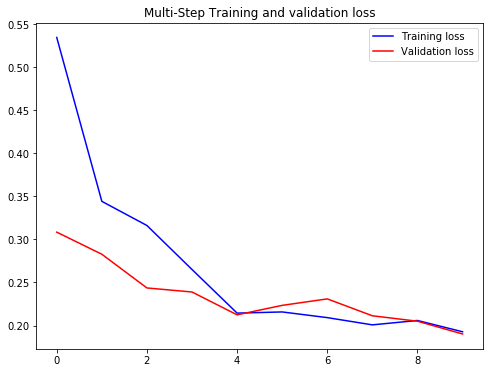

In [23]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
  
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### Ahora ya calculamos el mae de 300 registros de prueba:

In [25]:
mae_list = []
for x, y in val_data_multi.take(300):
    mae_list.append(tf.keras.metrics.mae(y[0].numpy(), multi_step_model.predict(x)[0]).numpy())
    
print('total mae: {}'.format(np.mean(mae_list)))

total mae: 0.20945130288600922


### Y ahora el 'mae' de los datos devueltos a su escala original de temperaturas

In [38]:
mae_scaled_list = []
for x, y in val_data_multi.take(100):
    x_denormalized = (x[0]*temps_std)+temps_mean
    y_denormalized = (y[0]*temps_std)+temps_mean
    mae_scaled_list.append(tf.keras.metrics.mae(y_denormalized[0], (multi_step_model.predict(x)[0]*temps_std)+temps_mean))
    
print('total mae_scaled: {}'.format(np.mean(mae_scaled_list)))

total mae_scaled: 2.0360615253448486


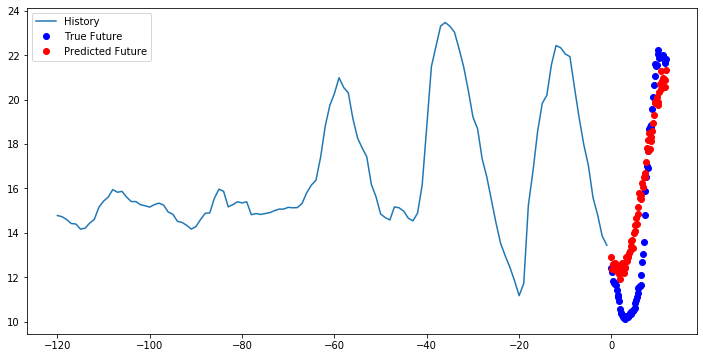

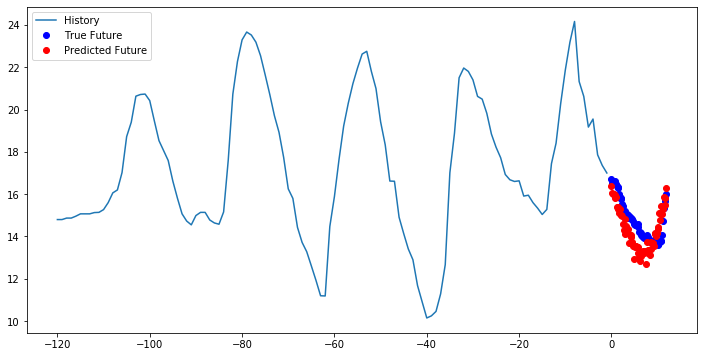

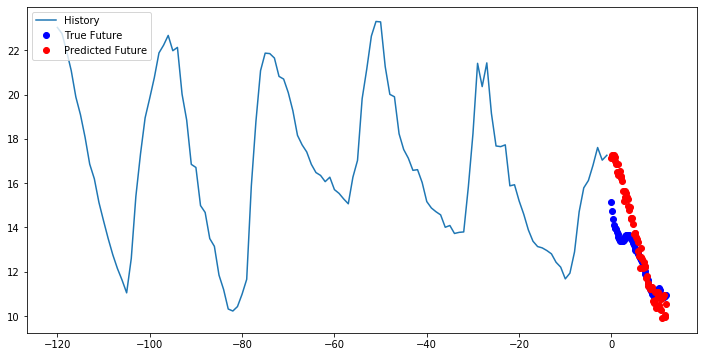

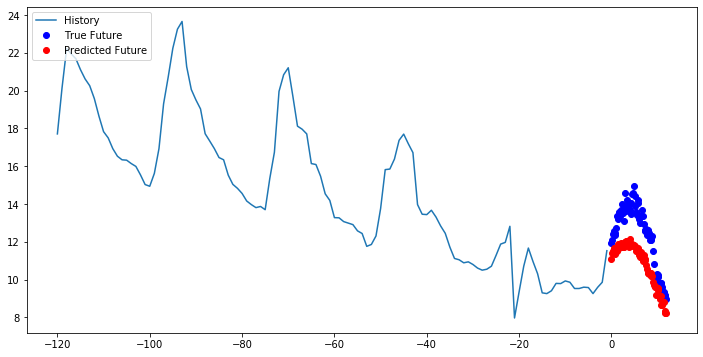

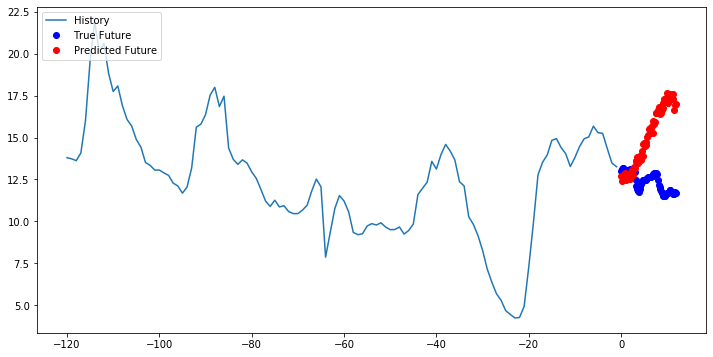

In [39]:

for x, y in val_data_multi.take(5):
    x_denormalized = (x[0])*temps_std+temps_mean
    y_denormalized = (y[0])*temps_std+temps_mean
    
    multi_step_plot(x_denormalized, y_denormalized, (multi_step_model.predict(x)[0]*temps_std)+temps_mean)

### Y con bayesian tuning:

In [42]:
from tensorflow import keras
from kerastuner import BayesianOptimization

def build_model_2(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=16,
                                        max_value=32,
                                        step=16), 
                                        #activation='relu', 
                                        return_sequences=True, 
                                        input_shape=x_train_multi.shape[-2:]))
    model.add(keras.layers.LSTM(units=hp.Int('units',min_value=16,
                                        max_value=32,
                                        step=16),  
                                        activation='relu'))
    model.add(keras.layers.Dense(72))

    model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
            
                   metrics=['mae'])
    return model

# define model
bayesian_opt_tuner_2 = BayesianOptimization(
    build_model_2,
    objective='mae',
    max_trials=3,
    executions_per_trial=1,
    directory=os.path.normpath('C:/keras_tuning'),
    project_name='timeseries_temp_ts_test_from_TF_ex_multivar_multistep_2',
    overwrite=True)

EVALUATION_INTERVAL = 200
EPOCHS = 10
bayesian_opt_tuner_2.search(train_data_multi, 
             epochs=EPOCHS,
             validation_data=val_data_multi,
             validation_steps=50,  
             steps_per_epoch=EVALUATION_INTERVAL)

=====================>...] - ETA: 1s - loss: 230184037.5778 - mae: 230184096.000181/200 [==========================>...] - ETA: 1s - loss: 228988948.1436 - mae: 228989008.000182/200 [==========================>...] - ETA: 1s - loss: 227809137.2637 - mae: 227809184.000183/200 [==========================>...] - ETA: 1s - loss: 226643429.0000 - mae: 226643472.000184/200 [==========================>...] - ETA: 1s - loss: 225484559.1685 - mae: 225484592.000185/200 [==========================>...] - ETA: 1s - loss: 224324684.3081 - mae: 224324720.000186/200 [==========================>...] - ETA: 1s - loss: 223173866.7043 - mae: 223173904.000187/200 [===========================>..] - ETA: 1s - loss: 222046725.7754 - mae: 222046768.000188/200 [===========================>..] - ETA: 1s - loss: 220929415.0000 - mae: 220929456.000189/200 [===========================>..] - ETA: 0s - loss: 219841532.2275 - mae: 219841568.000190/200 [===========================>..] - ETA: 0s - loss: 218743656.7316 

e: 0.270146/200 [====================>.........] - ETA: 4s - loss: 0.2706 - mae: 0.270147/200 [=====================>........] - ETA: 4s - loss: 0.2705 - mae: 0.270148/200 [=====================>........] - ETA: 4s - loss: 0.2704 - mae: 0.270149/200 [=====================>........] - ETA: 4s - loss: 0.2702 - mae: 0.270150/200 [=====================>........] - ETA: 4s - loss: 0.2701 - mae: 0.270151/200 [=====================>........] - ETA: 4s - loss: 0.2700 - mae: 0.270152/200 [=====================>........] - ETA: 4s - loss: 0.2698 - mae: 0.269153/200 [=====================>........] - ETA: 4s - loss: 0.2697 - mae: 0.269154/200 [======================>.......] - ETA: 4s - loss: 0.2694 - mae: 0.269155/200 [======================>.......] - ETA: 3s - loss: 0.2692 - mae: 0.269156/200 [======================>.......] - ETA: 3s - loss: 0.2690 - mae: 0.269157/200 [======================>.......] - ETA: 3s - loss: 0.2689 - mae: 0.268158/200 [======================>.......] - ETA: 3s - los

: 0.220146/200 [====================>.........] - ETA: 5s - loss: 0.2204 - mae: 0.220147/200 [=====================>........] - ETA: 5s - loss: 0.2203 - mae: 0.220148/200 [=====================>........] - ETA: 5s - loss: 0.2203 - mae: 0.220149/200 [=====================>........] - ETA: 5s - loss: 0.2202 - mae: 0.220150/200 [=====================>........] - ETA: 5s - loss: 0.2202 - mae: 0.220151/200 [=====================>........] - ETA: 5s - loss: 0.2202 - mae: 0.220152/200 [=====================>........] - ETA: 4s - loss: 0.2201 - mae: 0.220153/200 [=====================>........] - ETA: 4s - loss: 0.2201 - mae: 0.220154/200 [======================>.......] - ETA: 4s - loss: 0.2200 - mae: 0.220155/200 [======================>.......] - ETA: 4s - loss: 0.2200 - mae: 0.220156/200 [======================>.......] - ETA: 4s - loss: 0.2199 - mae: 0.219157/200 [======================>.......] - ETA: 4s - loss: 0.2198 - mae: 0.219158/200 [======================>.......] - ETA: 4s - loss

INFO:tensorflow:Oracle triggered exit


In [43]:
bayesian_opt_tuner_2.results_summary()

## 
* Queda pendiente ver por qué aquí evalúa cada 1 training sample
* PLOTEAR TRAIN-VALIDATOIN LOSSES DEL BEST MODEL
* PROBAR BASELINE MODEL!!!

In [44]:
best_MULTIVAR_MULTISTEP_LSTM_model = bayesian_opt_tuner_2.get_best_models(num_models=1)[0]


In [45]:
mae_list = []
for x, y in val_data_multi.take(300):
    mae_list.append(tf.keras.metrics.mae(y[0].numpy(), best_MULTIVAR_MULTISTEP_LSTM_model.predict(x)[0]).numpy())
    
print('total mae: {}'.format(np.mean(mae_list)))

total mae: 0.20954391360282898


### Y en su escala original

In [46]:
mae_scaled_list = []
for x, y in val_data_multi.take(100):
    x_denormalized = (x[0]*temps_std)+temps_mean
    y_denormalized = (y[0]*temps_std)+temps_mean
    mae_scaled_list.append(tf.keras.metrics.mae(y_denormalized[0], (best_MULTIVAR_MULTISTEP_LSTM_model.predict(x)[0]*temps_std)+temps_mean))
    
print('total mae_scaled: {}'.format(np.mean(mae_scaled_list)))

total mae_scaled: 2.0016016960144043


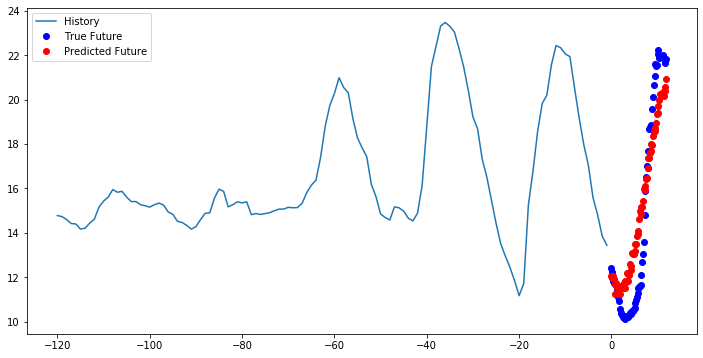

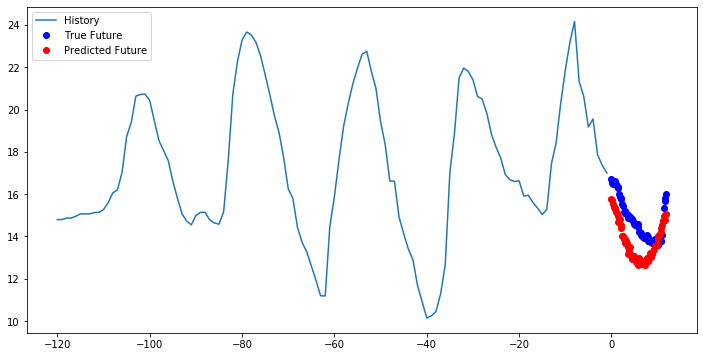

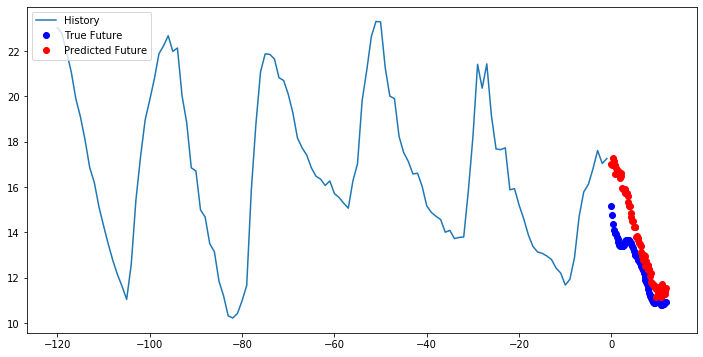

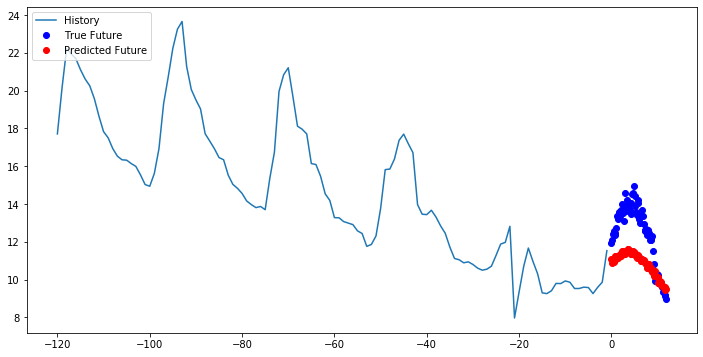

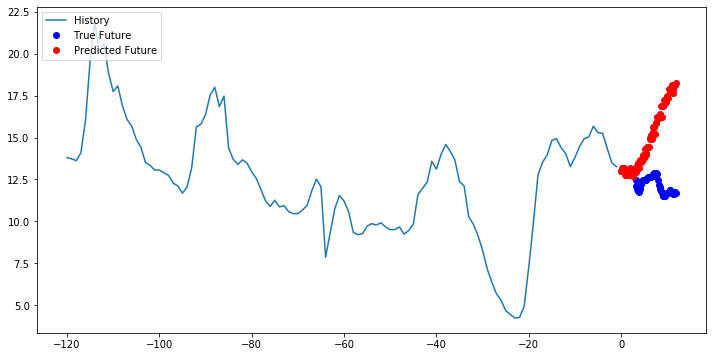

In [47]:
for x, y in val_data_multi.take(5):
    x_denormalized = (x[0])*temps_std+temps_mean
    y_denormalized = (y[0])*temps_std+temps_mean
    
    multi_step_plot(x_denormalized, y_denormalized, (best_MULTIVAR_MULTISTEP_LSTM_model.predict(x)[0]*temps_std)+temps_mean)

### De hecho las predicciones no parecen simplemente "imitar" el reciente pasado

### Save model

In [48]:
# serialize model to JSON
best_MULTIVAR_MULTISTEP_LSTM_model_json = best_MULTIVAR_MULTISTEP_LSTM_model.to_json()
with open("C:/keras_tuning/timeseries_temp_ts_test_from_TF_ex_multivar_multistep/best_MULTIVAR_MULTISTEP_LSTM_model_v2.json", "w") as json_file:
    json_file.write(best_MULTIVAR_MULTISTEP_LSTM_model_json)
# serialize weights to HDF5
best_MULTIVAR_MULTISTEP_LSTM_model.save_weights("C:/keras_tuning/timeseries_temp_ts_test_from_TF_ex_multivar_multistep/best_MULTIVAR_MULTISTEP_LSTM_model_v2.h5")
print("Saved model to disk")

Saved model to disk


Load model

In [49]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('C:/keras_tuning/timeseries_temp_ts_test_from_TF_ex_multivar_multistep/best_MULTIVAR_MULTISTEP_LSTM_model_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/keras_tuning/timeseries_temp_ts_test_from_TF_ex_multivar_multistep/best_MULTIVAR_MULTISTEP_LSTM_model_v2.h5")
print("Loaded model from disk")


Loaded model from disk
